# Prediction of Lorenz System Using Reservoir Computing
Apr 18, 2019. Guorui Shen, guorui233@outlook.com

This notebook is intended to predict Lorenz system, using reservoir computing techniques. Sturcture of adopted network is
\begin{eqnarray}
r(t+\Delta t) = (1-\alpha)\cdot r(t) + \alpha\cdot\text{tanh}\big(r(t)\cdot W_r^r + u(t)\cdot W_{in}^r + b_{in}\big),\\
y(t+\Delta t) = r(t+\Delta t)\cdot W_r^{out} + u(t)\cdot W_{in}^{out} + b_{out},
\end{eqnarray}
where $u(t), r(t), y(t), b_{in}, b_{out}$ are all row vectors, only $W_i^{out}, i=r, in,$ and $b_{out}$ are to be trained via Ridge regression, the remaning unknown weights and biases are assigned random values and no update.

Feature and label are chosen as 
\begin{eqnarray}
u(t) = \Big(x_1(t),x_2(t), x_3(t)\Big),\\
y(t+\Delta t) = \Big(x_1(t+\Delta t),x_2(t+\Delta t), x_3(t+\Delta t)\Big),
\end{eqnarray}
respectively, where $\Big(x_1(t), x_2(t), x_3(t)\Big)$ are state of Lorenz system
\begin{eqnarray}
\begin{aligned}
&\frac{dx_1}{dt}=\sigma(x_2-x_1),\\
&\frac{dx_2}{dt}=x_1(\rho-x_3)-x_2,\\
&\frac{dx_3}{dt}=x_1x_2-\beta x_3.
\end{aligned}
\end{eqnarray}

In [1]:
import scipy.io as sio
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [2]:
lrz = sio.loadmat('Lorenz.mat')
print len(lrz['states']), len(lrz['states'][0])

6000 3


Text(0.5,0,u't')

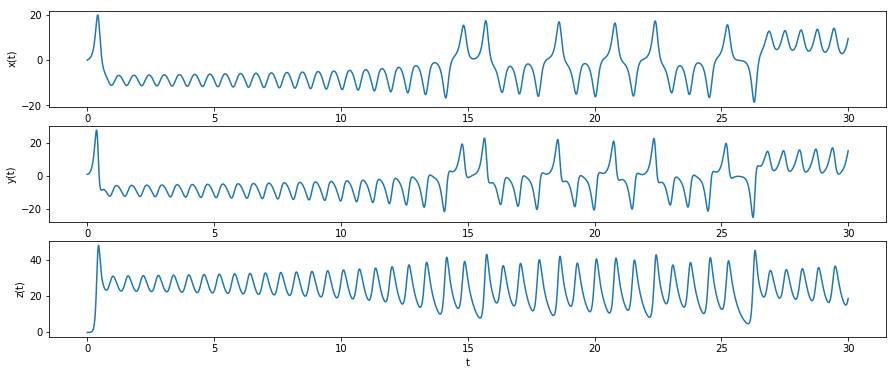

In [3]:
ylabel = ['x(t)', 'y(t)', 'z(t)']
plt.figure(figsize=(15, 6))
for i in range(3):
    plt.subplot(311+i)
    plt.plot(lrz['t'][0], lrz['states'][:, i])
    plt.ylabel(ylabel[i])
plt.xlabel('t')

In [4]:
np.random.seed(6) # 1~10 were already test
# seed vs prediction distance in descending order: (6, 19.0), (3, 18.4), (1, 18.1)

In [5]:
# parameters
num_train = 3500
num_pre_steps = 450 # forward predictions steps
num_initial = 1500
num_discard = 1000  # discard first num_discard steps
dim_in = 3          # dimension of input
dim_r = 300         # dimension of reservoir
dim_out = dim_in    # dimension of output
alpha = .3
lam = .00001 # regression parameter

In [6]:
Wr = np.random.rand(dim_r, dim_r)-.5
rhoW = max(abs(np.linalg.eig(Wr)[0]))
Wr *= 1.25 / rhoW
weights = {
    'in': np.random.rand(dim_in+1, dim_r)-.5, # 1 for bias
    'reservoir': Wr,
    'out': np.random.uniform(low=-1.0, high=1.0, size=(1+dim_in+dim_r, dim_out)) # 1+dim_in+dim_r is for bias+input+reservoir
}

In [7]:
R = np.random.uniform(low=-1, high=1, size=(num_train-num_initial, 1+dim_in+dim_r))
r = np.zeros((1, dim_r))
for t in range(num_discard, num_train): # discard first 300 steps
    u = lrz['states'][t]
    r = (1-alpha)*r + alpha*np.tanh(np.matmul(r, weights['reservoir']) + \
                                    np.matmul(np.hstack((1, u)), weights['in'])) # have bias
    if t>=num_initial:
        R[t-num_initial, :] = np.hstack((1,u,r[0]))
weights['out'] = np.matmul(np.linalg.inv(np.matmul(R.T, R) + lam*np.eye(1+dim_in+dim_r)),\
                           np.matmul(R.T, lrz['states'][num_initial+1:num_train+1, :]))

In [8]:
# prediction of states indexed by numbers from num_train to num_train+num_pre_steps
states_predict = np.random.uniform(low=-1, high=1, size=(num_pre_steps, dim_out))
u = lrz['states'][num_train]
for t in range(num_pre_steps):
    r = (1-alpha)*r + alpha*np.tanh(np.matmul(r, weights['reservoir']) + \
                                    np.matmul(np.hstack((1, u)), weights['in']))
    states_predict[t, :] = np.matmul(np.hstack((1,u,r[0])), weights['out'])
    u = states_predict[t, :]

t_test = lrz['t'][0][num_train+1:num_train+1+num_pre_steps]
states_test = lrz['states'][num_train+1:num_train+1+num_pre_steps, :]

t_train = lrz['t'][0][num_train-int(1.5*num_pre_steps):num_train+1]
states_train = lrz['states'][num_train-int(1.5*num_pre_steps):num_train+1, :]

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


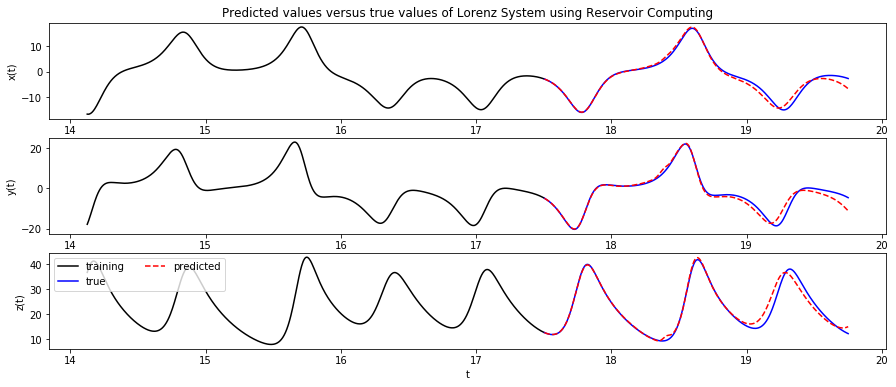

In [9]:
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Predicted values versus true values of Lorenz System using Reservoir Computing')
for i in range(dim_in):
    plt.subplot(311+i)
    plt.plot(t_train, states_train[:, i], 'k-', t_test, states_test[:, i], 'b-', t_test, states_predict[:, i], 'r--')
    plt.ylabel(ylabel[i])
plt.xlabel('t')
plt.legend(["training", "true", "predicted"], loc = 0, ncol = 2)